In [30]:
import zipfile
import os

# Zip file name (placed in the same directory as the current notebook)
zip_path = 'C:/Users/86173/Desktop/archive.zip'

# Extraction target folder
extract_to = 'archive_extracted'
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction completed! Files saved to:", extract_to)

✅ Extraction completed! Files saved to: archive_extracted


In [16]:
import os

for root, dirs, files in os.walk(extract_to):
    for file in files:
        print(file)



Google-Playstore.csv


In [17]:
import pandas as pd

csv_path = os.path.join(extract_to, 'Google-Playstore.csv')  
df = pd.read_csv(csv_path)

# 显示前几行
df.head()


,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


In [29]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['App Name', 'Category'], inplace=True)
df['Installs'] = df['Installs'].str.replace(r'[+,]', '', regex=True).astype('float')
df['Released'] = pd.to_datetime(df['Released'], errors='coerce')
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [28]:
print("=== Dataset Basic Information ===")
print(f"Dataset shape: {df.shape}")
print(f"Column names: {list(df.columns)}")
print("\nFirst 5 rows of data:")
print(df.head())

=== Dataset Basic Information ===
Dataset shape: (2312944, 27)
Column names: ['App Name', 'App Id', 'Category', 'Rating', 'Rating Count', 'Installs', 'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Currency', 'Size', 'Minimum Android', 'Developer Id', 'Developer Website', 'Developer Email', 'Released', 'Last Updated', 'Content Rating', 'Privacy Policy', 'Ad Supported', 'In App Purchases', 'Editors Choice', 'Scraped Time', 'Rating_Count', 'Price_Clean', 'Installs_Clean']

First 5 rows of data:
                                            App Name  \
0                                            Gakondo   
1                                Ampere Battery Info   
2                                             Vibook   
3  Smart City Trichy Public Service Vehicles 17UC...   
4                                            GROW.me   

                       App Id       Category  Rating  Rating Count Installs  \
0         com.ishakwe.gakondo      Adventure     0.0           0.0      10+ 

In [27]:
# ===============================
# 1. Data Preprocessing and Cleaning
# ===============================

def clean_installs(installs_str):
    """Clean installation count data"""
    if pd.isna(installs_str):
        return np.nan
    # Remove commas and plus signs
    clean_str = str(installs_str).replace(',', '').replace('+', '')
    try:
        return float(clean_str)
    except:
        return np.nan

def clean_price(price):
    """Clean price data"""
    if pd.isna(price):
        return 0.0
    if isinstance(price, str):
        # Remove currency symbols
        price = price.replace('$', '').replace('€', '').replace('£', '')
        try:
            return float(price)
        except:
            return 0.0
    return float(price)

# Data cleaning
print("\n=== Data Cleaning ===")
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Rating_Count'] = pd.to_numeric(df['Rating Count'], errors='coerce')
df['Price_Clean'] = df['Price'].apply(clean_price)
df['Installs_Clean'] = df['Maximum Installs'].apply(clean_installs)


# Remove missing values and outliers
df_clean = df.dropna(subset=['Rating', 'Price_Clean', 'Installs_Clean'])
# Remove apps with rating of 0 (typically indicates no ratings)
df_clean = df_clean[df_clean['Rating'] > 0]
# Remove apps with 0 installations
df_clean = df_clean[df_clean['Installs_Clean'] > 0]

print(f"Cleaned dataset shape: {df_clean.shape}")

# For large datasets, we can perform sampling to improve analysis efficiency
if len(df_clean) > 100000:
    print("Dataset is large, performing stratified sampling...")
    # Perform stratified sampling by category
    sample_size = min(50000, len(df_clean))
    df_sample = df_clean.groupby('Category', group_keys=False).apply(
        lambda x: x.sample(min(len(x), max(1, int(sample_size * len(x) / len(df_clean)))), 
                          random_state=42)
    ).reset_index(drop=True)
    print(f"Sampled dataset shape: {df_sample.shape}")
    # Use sampled data for subsequent analysis
    df_analysis = df_sample.copy()
else:
    df_analysis = df_clean.copy()


=== Data Cleaning ===
Cleaned dataset shape: (1230156, 27)
Dataset is large, performing stratified sampling...
Sampled dataset shape: (49976, 27)


In [26]:
# ===============================
# 2. Descriptive Statistical Analysis
# ===============================

print("\n=== Descriptive Statistical Analysis ===")
stats_summary = df_analysis[['Rating', 'Price_Clean', 'Installs_Clean']].describe()
print(stats_summary)

# Add some additional statistical information
print(f"\nAdditional Statistics:")
print(f"Percentage of free apps: {(df_analysis['Price_Clean'] == 0).mean():.1%}")
print(f"Percentage of paid apps: {(df_analysis['Price_Clean'] > 0).mean():.1%}")
print(f"Average rating: {df_analysis['Rating'].mean():.2f}")
print(f"Median rating: {df_analysis['Rating'].median():.2f}")
print(f"Percentage of high-rated apps (≥4.0): {(df_analysis['Rating'] >= 4.0).mean():.1%}")
print(f"Total number of categories: {df_analysis['Category'].nunique()}")
print(f"Most popular category: {df_analysis['Category'].value_counts().head(1).index[0]}")


=== Descriptive Statistical Analysis ===
             Rating   Price_Clean  Installs_Clean
count  49976.000000  49976.000000    4.997600e+04
mean       4.098295      0.095731    4.800345e+05
std        0.690297      2.255652    1.170030e+07
min        1.000000      0.000000    1.000000e+00
25%        3.800000      0.000000    1.287000e+03
50%        4.200000      0.000000    5.672000e+03
75%        4.600000      0.000000    3.431350e+04
max        5.000000    399.990000    1.521047e+09

Additional Statistics:
Percentage of free apps: 97.9%
Percentage of paid apps: 2.1%
Average rating: 4.10
Median rating: 4.20
Percentage of high-rated apps (≥4.0): 66.2%
Total number of categories: 48
Most popular category: Education


In [23]:
# ===============================
# 3. Correlation Analysis (Pearson and Spearman)
# ===============================

print("\n=== Correlation Analysis ===")

# Select analysis variables
analysis_vars = ['Rating', 'Price_Clean', 'Installs_Clean']
correlation_data = df_analysis[analysis_vars]

# Pearson correlation coefficient
pearson_corr = correlation_data.corr(method='pearson')
print("Pearson Correlation Matrix:")
print(pearson_corr)

# Spearman correlation coefficient
spearman_corr = correlation_data.corr(method='spearman')
print("\nSpearman Correlation Matrix:")
print(spearman_corr)

# Significance testing
def correlation_significance_test(data, method='pearson'):
    """Calculate the significance of correlation coefficients"""
    variables = data.columns
    n = len(variables)
    p_values = np.zeros((n, n))
    
    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            if i != j:
                if method == 'pearson':
                    corr, p_val = stats.pearsonr(data[var1], data[var2])
                else:  # spearman
                    corr, p_val = stats.spearmanr(data[var1], data[var2])
                p_values[i, j] = p_val
            else:
                p_values[i, j] = 0
    
    return pd.DataFrame(p_values, index=variables, columns=variables)

pearson_p_values = correlation_significance_test(correlation_data, 'pearson')
spearman_p_values = correlation_significance_test(correlation_data, 'spearman')

print("\nPearson correlation coefficient p-values:")
print(pearson_p_values)
print("\nSpearman correlation coefficient p-values:")
print(spearman_p_values)


=== Correlation Analysis ===
Pearson Correlation Matrix:
                  Rating  Price_Clean  Installs_Clean
Rating          1.000000     0.002953        0.005001
Price_Clean     0.002953     1.000000       -0.001676
Installs_Clean  0.005001    -0.001676        1.000000

Spearman Correlation Matrix:
                  Rating  Price_Clean  Installs_Clean
Rating          1.000000     0.007543       -0.325544
Price_Clean     0.007543     1.000000       -0.083178
Installs_Clean -0.325544    -0.083178        1.000000

Pearson correlation coefficient p-values:
                  Rating  Price_Clean  Installs_Clean
Rating          0.000000     0.509200        0.263536
Price_Clean     0.509200     0.000000        0.707874
Installs_Clean  0.263536     0.707874        0.000000

Spearman correlation coefficient p-values:
                  Rating   Price_Clean  Installs_Clean
Rating          0.000000  9.175401e-02    0.000000e+00
Price_Clean     0.091754  0.000000e+00    1.954818e-77
Installs_Cle

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


=== Enhanced Advanced Machine Learning Modeling Analysis (Download Volume Prediction) ===
1. Data preprocessing and feature engineering...
✓ In App Purchases variable added
Creating feature engineering...
Number of features: 36
Feature list: ['Rating_filled', 'Rating_squared', 'Rating_cubed', 'High_Rating', 'Low_Rating', 'Rating_deviation', 'Price_filled', 'Price_log', 'Is_Free', 'Is_Premium', 'Ad_Supported_Binary', 'In_App_Purchases_Binary', 'Rating_Price_interaction', 'Rating_Free_interaction', 'Rating_Ad_interaction', 'Rating_IAP_interaction', 'Price_IAP_interaction', 'Free_IAP_interaction', 'Ad_IAP_interaction', 'Monetization_Strategy_encoded', 'Size_filled', 'Size_log', 'Size_squared', 'Is_Large_App', 'Is_Small_App', 'Size_deviation', 'Size_Price_interaction', 'Size_Rating_interaction', 'Size_Ad_interaction', 'Size_IAP_interaction', 'Category_encoded', 'Category_popularity', 'Category_competition', 'App_name_length', 'App_name_words', 'Has_numbers']

In App Purchases distribution

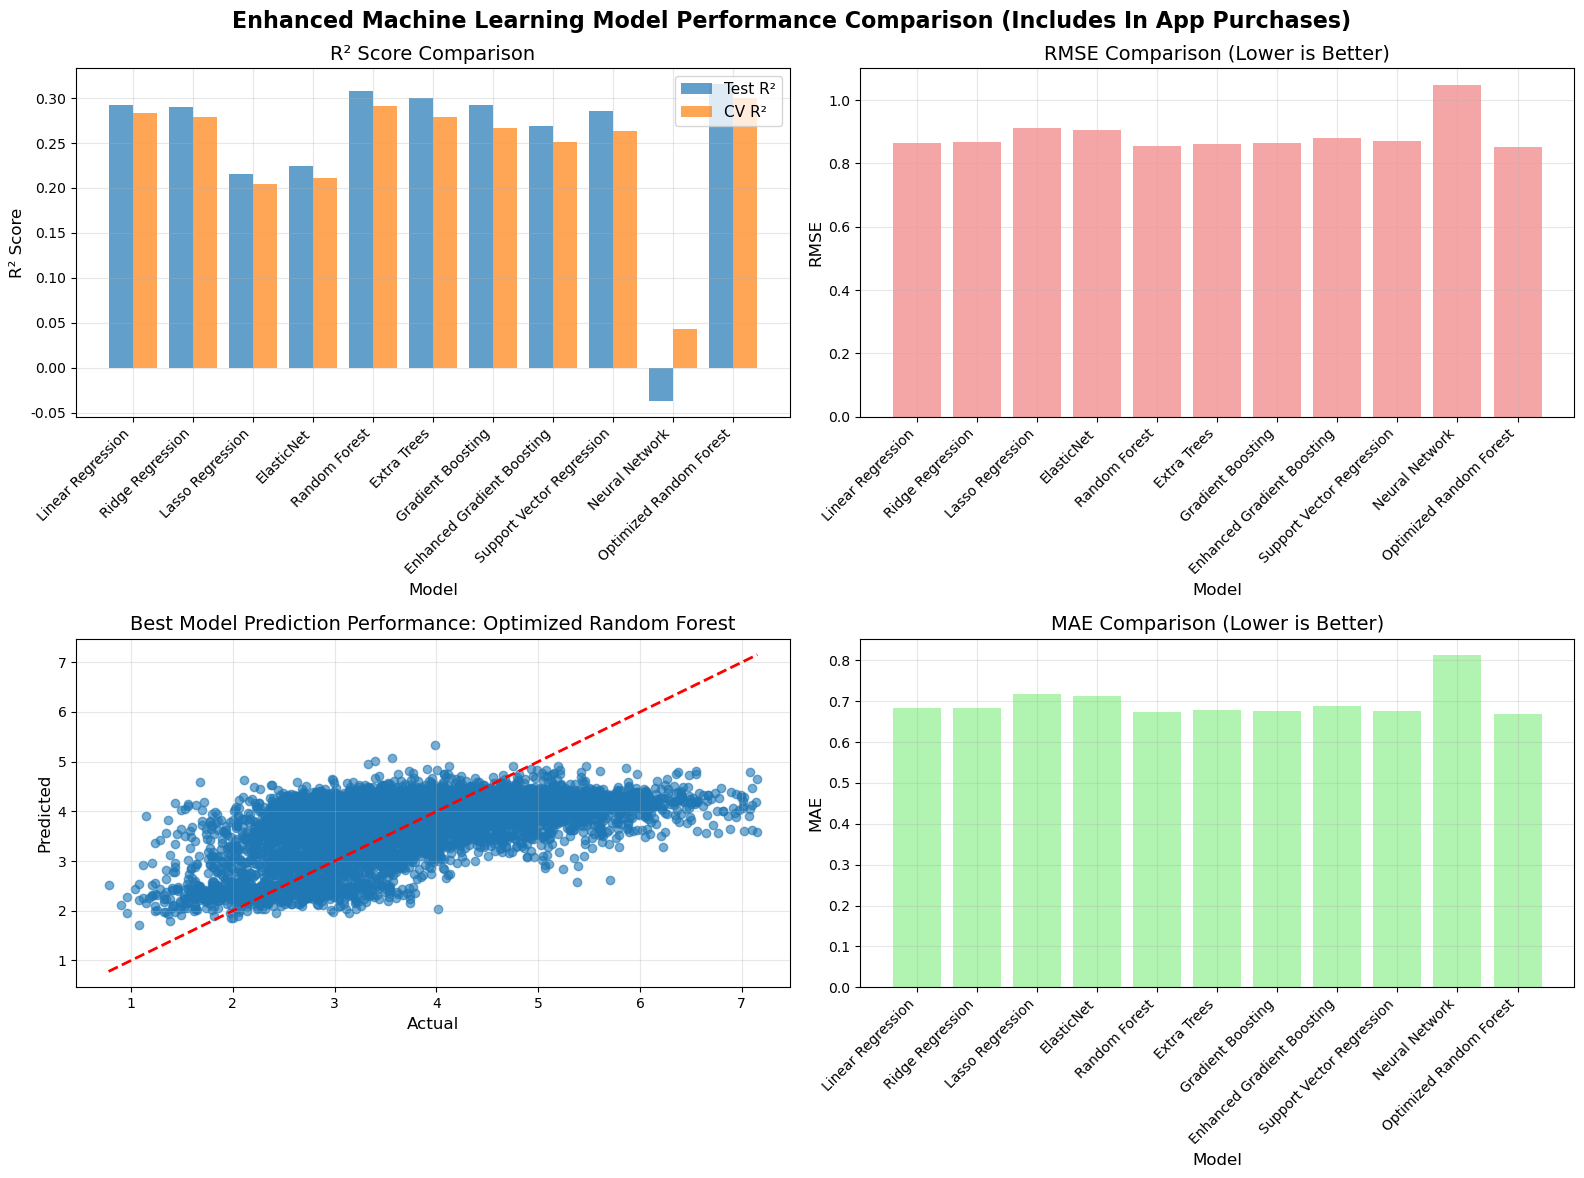


=== Feature Importance Analysis ===
Top 10 Most Important Features:
                    feature  importance
7   Rating_Free_interaction    0.117738
2              Rating_cubed    0.111147
0             Rating_filled    0.109639
1            Rating_squared    0.097618
21      Category_popularity    0.061937
4          Rating_deviation    0.058526
22          App_name_length    0.057863
20         Category_encoded    0.050233
17  Size_Rating_interaction    0.041122
16           Size_deviation    0.034318


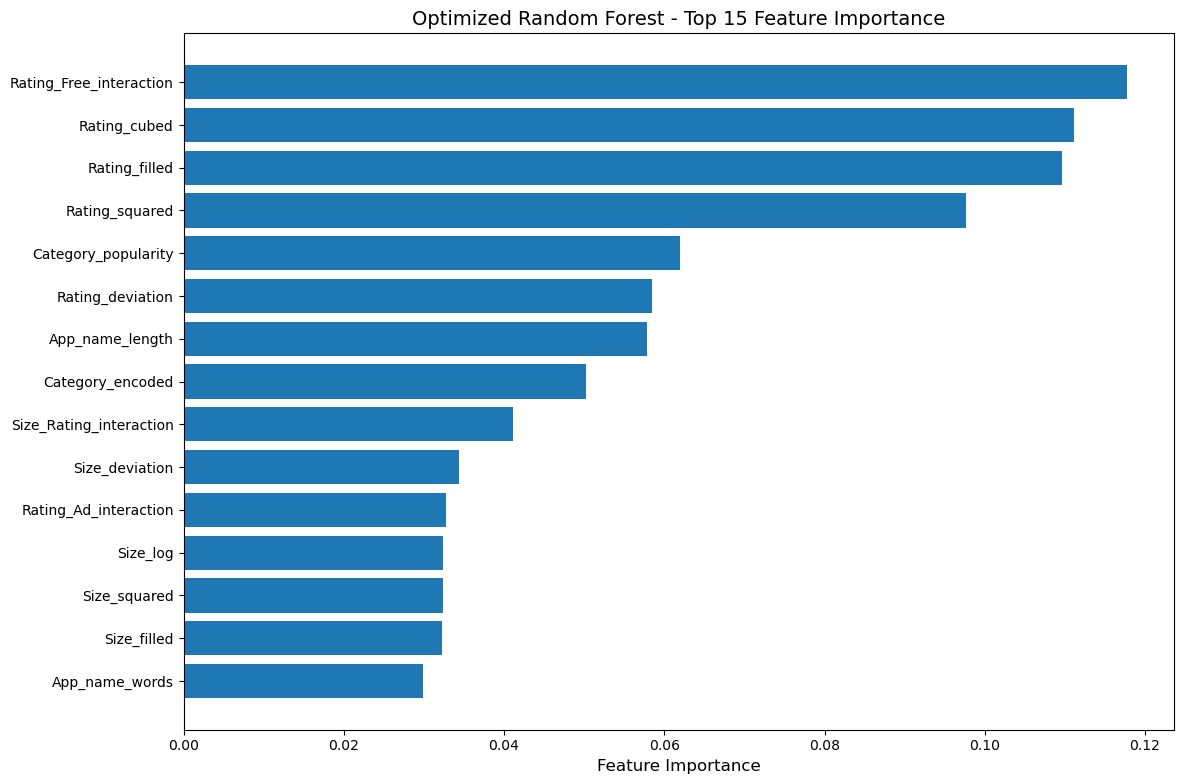


In App Purchases Related Feature Importance:
                          feature  importance
11  Monetization_Strategy_encoded    0.021686
19           Size_IAP_interaction    0.004017
9          Rating_IAP_interaction    0.002657
6         In_App_Purchases_Binary    0.001621
10           Free_IAP_interaction    0.001273

=== Residual Analysis ===
Residual statistics:
  Mean: -0.0018
  Standard deviation: 0.8512
  Maximum positive residual: 3.5598
  Maximum negative residual: -2.9008


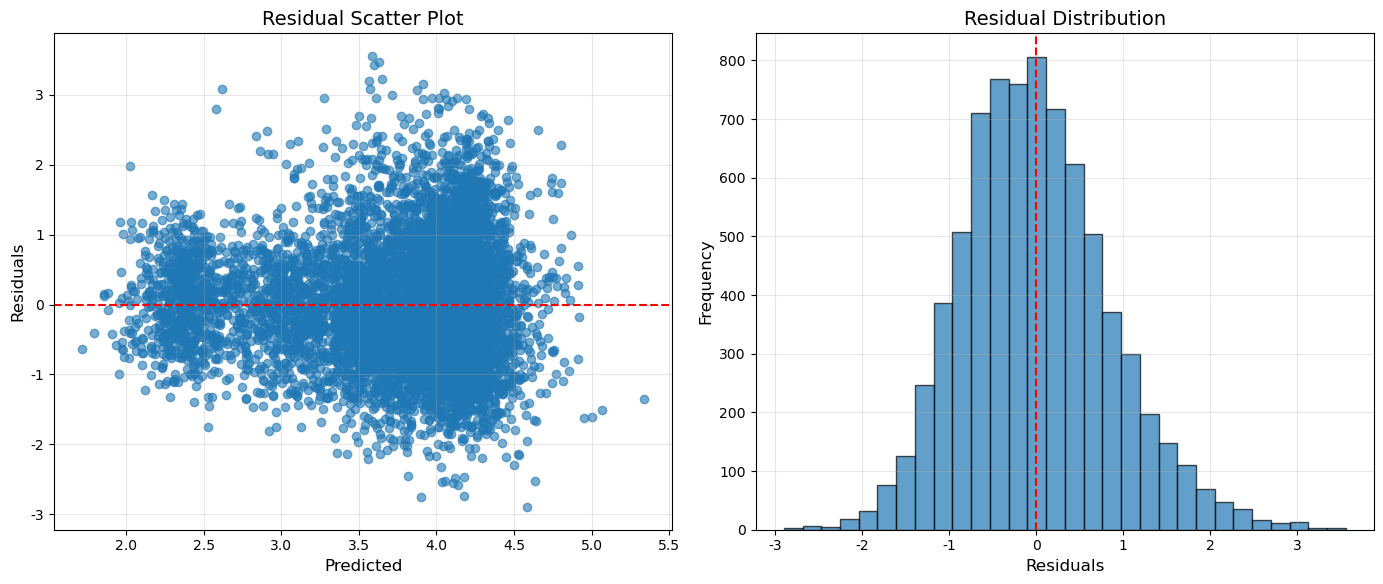


=== Model Prediction Examples ===
Actual       Predicted    Error        Relative Error
--------------------------------------------------
4.8963       4.2079       0.6884       14.06       %
2.9340       3.2474       0.3134       10.68       %
4.3064       4.1044       0.2020       4.69        %
4.0134       4.1354       0.1220       3.04        %
5.1820       3.9587       1.2234       23.61       %

=== In App Purchases Impact Analysis ===
Hypothetical scenario analysis (all other conditions equal):
  Expected downloads without IAP: 22,099
  Expected downloads with IAP: 21,980
  IAP impact ratio: 0.99x
  IAP impact percentage: -0.5%

=== Monetization Strategy Analysis ===
Average performance of different monetization strategies:
(Format: Free_Ads_IAP)
                      Log_Installs                Rating_filled
                              mean  median  count          mean
Monetization_Strategy                                          
0_0_0                       3.1918  3.0932 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def advanced_ml_modeling_enhanced(df):
    """
    Enhanced Advanced Machine Learning Modeling: Using the number of downloads as the dependent variable, includes rich feature engineering.
    Newly added In App Purchases variable.
    """
    print("\n=== Enhanced Advanced Machine Learning Modeling Analysis (Download Volume Prediction) ===")
    
    df_model = df.copy()
    
    # 1. Data preprocessing and feature engineering
    print("1. Data preprocessing and feature engineering...")
    
    # Apply logarithmic transformation to the number of downloads
    df_model['Log_Installs'] = np.log10(df_model['Installs_Clean'] + 1)
    
    # 1.1 Handle missing values for basic features
    df_model['Rating_filled'] = df_model['Rating'].fillna(df_model['Rating'].mean())
    df_model['Price_filled'] = df_model['Price_Clean'].fillna(0)
    df_model['Ad_Supported_Binary'] = df_model['Ad Supported'].map({True: 1, False: 0}).fillna(0)
    
    # New: Handle In App Purchases variable
    df_model['In_App_Purchases_Binary'] = df_model['In App Purchases'].map({True: 1, False: 0}).fillna(0)
    print("✓ In App Purchases variable added")
    
    # Handle Size column
    if 'Size' in df_model.columns:
        # Extract the numerical part and convert to MB
        def extract_size_mb(size_str):
            if pd.isna(size_str) or size_str == 'Varies with device':
                return None
            try:
                size_str = str(size_str).replace(',', '')
                if 'M' in size_str:
                    return float(size_str.replace('M', ''))
                elif 'k' in size_str or 'K' in size_str:
                    return float(size_str.replace('k', '').replace('K', '')) / 1024
                elif 'G' in size_str:
                    return float(size_str.replace('G', '')) * 1024
                else:
                    # Assume it's the number of bytes
                    return float(size_str) / (1024 * 1024)
            except:
                return None
        
        df_model['Size_MB'] = df_model['Size'].apply(extract_size_mb)
        df_model['Size_filled'] = df_model['Size_MB'].fillna(df_model['Size_MB'].median())
    else:
        df_model['Size_filled'] = 0
    
    # 1.2 Create new features
    print("Creating feature engineering...")
    
    # Rating-related features
    df_model['Rating_squared'] = df_model['Rating_filled'] ** 2
    df_model['Rating_cubed'] = df_model['Rating_filled'] ** 3
    df_model['High_Rating'] = (df_model['Rating_filled'] >= 4.5).astype(int)
    df_model['Low_Rating'] = (df_model['Rating_filled'] <= 3.0).astype(int)
    df_model['Rating_deviation'] = np.abs(df_model['Rating_filled'] - df_model['Rating_filled'].mean())
    
    # Price-related features
    df_model['Is_Free'] = (df_model['Price_filled'] == 0).astype(int)
    df_model['Is_Premium'] = (df_model['Price_filled'] > 5).astype(int)
    df_model['Price_log'] = np.log10(df_model['Price_filled'] + 1)
    df_model['Price_tier'] = pd.cut(df_model['Price_filled'], 
                                   bins=[-0.1, 0, 1, 5, 20, 100], 
                                   labels=['Free', 'Low', 'Mid', 'High', 'Premium'])
    
    # Size-related features
    if df_model['Size_filled'].max() > 0:
        df_model['Size_log'] = np.log10(df_model['Size_filled'] + 1)
        df_model['Size_squared'] = df_model['Size_filled'] ** 2
        df_model['Is_Large_App'] = (df_model['Size_filled'] > df_model['Size_filled'].quantile(0.75)).astype(int)
        df_model['Is_Small_App'] = (df_model['Size_filled'] < df_model['Size_filled'].quantile(0.25)).astype(int)
        df_model['Size_deviation'] = np.abs(df_model['Size_filled'] - df_model['Size_filled'].mean())
    
    # Category-related features
    if 'Category' in df_model.columns:
        category_encoder = LabelEncoder()
        df_model['Category_encoded'] = category_encoder.fit_transform(df_model['Category'].fillna('Unknown'))
        
        # Category popularity
        category_popularity = df_model.groupby('Category')['Log_Installs'].mean()
        df_model['Category_popularity'] = df_model['Category'].map(category_popularity).fillna(category_popularity.mean())
        
        # Category competition (number of apps in the category)
        category_competition = df_model['Category'].value_counts()
        df_model['Category_competition'] = df_model['Category'].map(category_competition).fillna(category_competition.mean())
    
    # Text features (if app name is available)
    if 'App' in df_model.columns:
        df_model['App_name_length'] = df_model['App'].str.len()
        df_model['App_name_words'] = df_model['App'].str.split().str.len()
        df_model['Has_numbers'] = df_model['App'].str.contains(r'\d', na=False).astype(int)
    elif 'App Name' in df_model.columns:
        df_model['App_name_length'] = df_model['App Name'].str.len()
        df_model['App_name_words'] = df_model['App Name'].str.split().str.len()
        df_model['Has_numbers'] = df_model['App Name'].str.contains(r'\d', na=False).astype(int)
    
    # Interaction features (includes new In App Purchases variable)
    df_model['Rating_Price_interaction'] = df_model['Rating_filled'] * df_model['Price_filled']
    df_model['Rating_Free_interaction'] = df_model['Rating_filled'] * df_model['Is_Free']
    df_model['Rating_Ad_interaction'] = df_model['Rating_filled'] * df_model['Ad_Supported_Binary']
    
    # New: In App Purchases related interaction features
    df_model['Rating_IAP_interaction'] = df_model['Rating_filled'] * df_model['In_App_Purchases_Binary']
    df_model['Price_IAP_interaction'] = df_model['Price_filled'] * df_model['In_App_Purchases_Binary']
    df_model['Free_IAP_interaction'] = df_model['Is_Free'] * df_model['In_App_Purchases_Binary']
    df_model['Ad_IAP_interaction'] = df_model['Ad_Supported_Binary'] * df_model['In_App_Purchases_Binary']
    
    # Monetization strategy combination feature
    df_model['Monetization_Strategy'] = (
        df_model['Is_Free'].astype(str) + '_' + 
        df_model['Ad_Supported_Binary'].astype(str) + '_' + 
        df_model['In_App_Purchases_Binary'].astype(str)
    )
    
    # Encode monetization strategy as numerical
    monetization_encoder = LabelEncoder()
    df_model['Monetization_Strategy_encoded'] = monetization_encoder.fit_transform(df_model['Monetization_Strategy'])
    
    if df_model['Size_filled'].max() > 0:
        df_model['Size_Price_interaction'] = df_model['Size_filled'] * df_model['Price_filled']
        df_model['Size_Rating_interaction'] = df_model['Size_filled'] * df_model['Rating_filled']
        df_model['Size_Ad_interaction'] = df_model['Size_filled'] * df_model['Ad_Supported_Binary']
        df_model['Size_IAP_interaction'] = df_model['Size_filled'] * df_model['In_App_Purchases_Binary']
    
    # 1.3 Select modeling features
    feature_columns = [
        'Rating_filled', 'Rating_squared', 'Rating_cubed', 'High_Rating', 'Low_Rating', 'Rating_deviation',
        'Price_filled', 'Price_log', 'Is_Free', 'Is_Premium',
        'Ad_Supported_Binary',
        'In_App_Purchases_Binary',  # New main feature
        'Rating_Price_interaction', 'Rating_Free_interaction', 'Rating_Ad_interaction',
        'Rating_IAP_interaction', 'Price_IAP_interaction', 'Free_IAP_interaction', 'Ad_IAP_interaction',  # New interaction features
        'Monetization_Strategy_encoded'  # New monetization strategy feature
    ]
    
    # Add Size-related features
    if df_model['Size_filled'].max() > 0:
        feature_columns.extend([
            'Size_filled', 'Size_log', 'Size_squared', 'Is_Large_App', 'Is_Small_App', 'Size_deviation',
            'Size_Price_interaction', 'Size_Rating_interaction', 'Size_Ad_interaction', 'Size_IAP_interaction'
        ])
    
    # Add category features
    if 'Category_encoded' in df_model.columns:
        feature_columns.extend(['Category_encoded', 'Category_popularity', 'Category_competition'])
    
    # Add text features
    if 'App_name_length' in df_model.columns:
        feature_columns.extend(['App_name_length', 'App_name_words', 'Has_numbers'])
    
    # Prepare data
    X = df_model[feature_columns].fillna(0)
    y = df_model['Log_Installs'].fillna(df_model['Log_Installs'].mean())
    
    print(f"Number of features: {len(feature_columns)}")
    print(f"Feature list: {feature_columns}")
    
    # Output basic statistics for In App Purchases
    iap_stats = df_model['In_App_Purchases_Binary'].value_counts()
    print(f"\nIn App Purchases distribution:")
    print(f"  No in-app purchases (0): {iap_stats.get(0, 0)} ({iap_stats.get(0, 0)/len(df_model)*100:.1f}%)")
    print(f"  Has in-app purchases (1): {iap_stats.get(1, 0)} ({iap_stats.get(1, 0)/len(df_model)*100:.1f}%)")
    
    # Analyze the relationship between In App Purchases and downloads
    iap_download_comparison = df_model.groupby('In_App_Purchases_Binary')['Log_Installs'].agg(['mean', 'median', 'count'])
    print(f"\nRelationship between In App Purchases and downloads:")
    print(iap_download_comparison)
    
    # Remove outliers
    z_scores = np.abs(stats.zscore(X.select_dtypes(include=[np.number])))
    outlier_mask = (z_scores < 3).all(axis=1) & (np.abs(stats.zscore(y)) < 3)
    
    X_clean = X[outlier_mask]
    y_clean = y[outlier_mask]
    
    print(f"\nOriginal data size: {len(X)}")
    print(f"Cleaned data size: {len(X_clean)}")
    
    # 2. Feature selection
    print("\n2. Feature selection...")
    
    # Use SelectKBest to select the most important features
    selector = SelectKBest(score_func=f_regression, k=min(25, len(feature_columns)))  # Increase the number of features
    X_selected = selector.fit_transform(X_clean, y_clean)
    selected_features = [feature_columns[i] for i in selector.get_support(indices=True)]
    
    print(f"Number of selected features: {len(selected_features)}")
    print(f"Selected features: {selected_features}")
    
    # Check if In App Purchases related features are selected
    iap_features = [f for f in selected_features if 'IAP' in f or 'In_App_Purchases' in f or 'Monetization' in f]
    print(f"Selected In App Purchases related features: {iap_features}")
    
    # 3. Data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y_clean, test_size=0.2, random_state=42
    )
    
    # 4. Define enhanced model collection
    print("\n3. Model definition and training...")
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
        'Extra Trees': ExtraTreesRegressor(n_estimators=200, max_depth=15, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=200, max_depth=8, learning_rate=0.1, random_state=42
        ),
        'Enhanced Gradient Boosting': GradientBoostingRegressor(
            n_estimators=300, max_depth=10, learning_rate=0.05, 
            subsample=0.8, max_features='sqrt', random_state=42
        ),
        'Support Vector Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR(kernel='rbf', C=10.0, gamma='scale'))
        ]),
        'Neural Network': Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', MLPRegressor(
                hidden_layer_sizes=(150, 100, 50), 
                max_iter=2000, 
                learning_rate_init=0.001,
                random_state=42
            ))
        ])
    }
    
    # 5. Model training and evaluation
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Predict
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Calculate evaluation metrics
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
            
            results[name] = {
                'model': model,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'y_pred_test': y_pred_test
            }
            
        except Exception as e:
            print(f"Model {name} training failed: {str(e)}")
            continue
    
    # 6. Hyperparameter optimization (for the most promising models)
    print("\n4. Hyperparameter optimization...")
    
    # Optimize Random Forest
    rf_params = {
        'n_estimators': [200, 300, 500],
        'max_depth': [15, 20, 25],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42),
        rf_params,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    rf_grid.fit(X_train, y_train)
    optimized_rf = rf_grid.best_estimator_
    
    # Complete evaluation of optimized Random Forest
    y_pred_rf_train = optimized_rf.predict(X_train)
    y_pred_rf_test = optimized_rf.predict(X_test)
    
    rf_opt_train_r2 = r2_score(y_train, y_pred_rf_train)
    rf_opt_test_r2 = r2_score(y_test, y_pred_rf_test)
    rf_opt_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
    rf_opt_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
    rf_opt_test_mae = mean_absolute_error(y_test, y_pred_rf_test)
    
    # Cross-validation
    rf_cv_scores = cross_val_score(optimized_rf, X_train, y_train, cv=5, scoring='r2')
    
    results['Optimized Random Forest'] = {
        'model': optimized_rf,
        'train_r2': rf_opt_train_r2,
        'test_r2': rf_opt_test_r2,
        'train_rmse': rf_opt_train_rmse,
        'test_rmse': rf_opt_test_rmse,
        'test_mae': rf_opt_test_mae,
        'cv_mean': rf_cv_scores.mean(),
        'cv_std': rf_cv_scores.std(),
        'y_pred_test': y_pred_rf_test,
        'best_params': rf_grid.best_params_
    }
    
    print(f"Optimized Random Forest - Training R²: {rf_opt_train_r2:.4f}")
    print(f"Optimized Random Forest - Test R²: {rf_opt_test_r2:.4f}")
    print(f"Optimized Random Forest - Test RMSE: {rf_opt_test_rmse:.4f}")
    print(f"Optimized Random Forest - Test MAE: {rf_opt_test_mae:.4f}")
    print(f"Optimized Random Forest - Cross-validation R²: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
    print(f"Best parameters: {rf_grid.best_params_}")
    
    # 7. Model performance summary
    print("\n=== Model Performance Summary ===")
    performance_summary = []
    
    for name, result in results.items():
        performance_summary.append({
            'Model': name,
            'Test R²': f"{result['test_r2']:.4f}",
            'CV R²': f"{result['cv_mean']:.4f} ± {result['cv_std']:.4f}",
            'RMSE': f"{result['test_rmse']:.4f}",
            'MAE': f"{result['test_mae']:.4f}"
        })
    
    # Sort by Test R²
    performance_summary.sort(key=lambda x: float(x['Test R²']), reverse=True)
    
    # Print table
    print(f"{'Model':<25} {'Test R²':<12} {'CV R²':<20} {'RMSE':<10} {'MAE':<10}")
    print("-" * 85)
    for item in performance_summary:
        print(f"{item['Model']:<25} {item['Test R²']:<12} {item['CV R²']:<20} {item['RMSE']:<10} {item['MAE']:<10}")
    
    # Find the best model
    best_model_name = performance_summary[0]['Model']
    best_result = results[best_model_name]
    
    print(f"\n=== Best Model: {best_model_name} ===")
    print(f"Test R²: {best_result['test_r2']:.4f}")
    print(f"Cross-validation R²: {best_result['cv_mean']:.4f} ± {best_result['cv_std']:.4f}")
    print(f"RMSE: {best_result['test_rmse']:.4f}")
    print(f"MAE: {best_result['test_mae']:.4f}")
    
    if 'best_params' in best_result:
        print(f"Best parameters: {best_result['best_params']}")
    
    # 8. Model performance visualization
    print("\n5. Model performance visualization...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Enhanced Machine Learning Model Performance Comparison (Includes In App Purchases)', fontsize=16, fontweight='bold')
    
    # 8.1 R² score comparison
    model_names = list(results.keys())
    test_r2_scores = [results[name]['test_r2'] for name in model_names]
    cv_scores = [results[name]['cv_mean'] for name in model_names]
    
    x_pos = np.arange(len(model_names))
    
    axes[0, 0].bar(x_pos - 0.2, test_r2_scores, 0.4, label='Test R²', alpha=0.7)
    axes[0, 0].bar(x_pos + 0.2, cv_scores, 0.4, label='CV R²', alpha=0.7)
    axes[0, 0].set_xlabel('Model')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_title('R² Score Comparison')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 8.2 RMSE comparison
    test_rmse_scores = [results[name]['test_rmse'] for name in model_names]
    
    axes[0, 1].bar(x_pos, test_rmse_scores, alpha=0.7, color='lightcoral')
    axes[0, 1].set_xlabel('Model')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].set_title('RMSE Comparison (Lower is Better)')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 8.3 Best model's predicted vs actual values
    axes[1, 0].scatter(y_test, best_result['y_pred_test'], alpha=0.6)
    axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    axes[1, 0].set_title(f'Best Model Prediction Performance: {best_model_name}')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 8.4 MAE comparison
    test_mae_scores = [results[name]['test_mae'] for name in model_names]
    
    axes[1, 1].bar(x_pos, test_mae_scores, alpha=0.7, color='lightgreen')
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].set_title('MAE Comparison (Lower is Better)')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 9. Feature importance analysis (if tree-based model)
    if hasattr(best_result['model'], 'feature_importances_'):
        print("\n=== Feature Importance Analysis ===")
        feature_importance = best_result['model'].feature_importances_
        feature_names = selected_features
        
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        print("Top 10 Most Important Features:")
        print(importance_df.head(10))
        
        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{best_model_name} - Top 15 Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        # Analyze importance of In App Purchases related features
        iap_importance = importance_df[importance_df['feature'].str.contains('IAP|In_App_Purchases|Monetization', case=False)]
        if not iap_importance.empty:
            print(f"\nIn App Purchases Related Feature Importance:")
            print(iap_importance)
    
    # 10. Residual analysis
    print("\n=== Residual Analysis ===")
    residuals = y_test - best_result['y_pred_test']
    
    print(f"Residual statistics:")
    print(f"  Mean: {residuals.mean():.4f}")
    print(f"  Standard deviation: {residuals.std():.4f}")
    print(f"  Maximum positive residual: {residuals.max():.4f}")
    print(f"  Maximum negative residual: {residuals.min():.4f}")
    
    # Residual visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Residual scatter plot
    axes[0].scatter(best_result['y_pred_test'], residuals, alpha=0.6)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title('Residual Scatter Plot')
    axes[0].grid(True, alpha=0.3)
    
    # Residual histogram
    axes[1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1].axvline(x=0, color='r', linestyle='--')
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Residual Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 11. Model prediction examples
    print("\n=== Model Prediction Examples ===")
    
    # Select a few test samples for prediction demonstration
    sample_indices = np.random.choice(len(y_test), 5, replace=False)
    
    print(f"{'Actual':<12} {'Predicted':<12} {'Error':<12} {'Relative Error':<12}")
    print("-" * 50)
    
    for idx in sample_indices:
        actual = y_test.iloc[idx]
        predicted = best_result['y_pred_test'][idx]
        error = abs(actual - predicted)
        relative_error = error / actual * 100 if actual != 0 else 0
        
        print(f"{actual:<12.4f} {predicted:<12.4f} {error:<12.4f} {relative_error:<12.2f}%")
    
    # 12. In App Purchases impact analysis
    print("\n=== In App Purchases Impact Analysis ===")
    
    # Create hypothetical scenarios to analyze IAP impact
    if 'In_App_Purchases_Binary' in selected_features:
        # Get a sample data point
        sample_data = X_test[0:1].copy()
        
        # Create two versions: with IAP and without IAP
        sample_no_iap = sample_data.copy()
        sample_with_iap = sample_data.copy()
        
        # Find the index of IAP feature
        iap_idx = selected_features.index('In_App_Purchases_Binary')
        sample_no_iap[0, iap_idx] = 0
        sample_with_iap[0, iap_idx] = 1
        
        # Predict downloads in both scenarios
        pred_no_iap = best_result['model'].predict(sample_no_iap)[0]
        pred_with_iap = best_result['model'].predict(sample_with_iap)[0]
        
        # Convert back to original download numbers
        downloads_no_iap = 10 ** pred_no_iap - 1
        downloads_with_iap = 10 ** pred_with_iap - 1
        
        impact_ratio = downloads_with_iap / downloads_no_iap if downloads_no_iap > 0 else 1
        impact_percentage = (impact_ratio - 1) * 100
        
        print(f"Hypothetical scenario analysis (all other conditions equal):")
        print(f"  Expected downloads without IAP: {downloads_no_iap:,.0f}")
        print(f"  Expected downloads with IAP: {downloads_with_iap:,.0f}")
        print(f"  IAP impact ratio: {impact_ratio:.2f}x")
        print(f"  IAP impact percentage: {impact_percentage:+.1f}%")
    
    # 13. Monetization strategy analysis
    print("\n=== Monetization Strategy Analysis ===")
    
    if 'Monetization_Strategy_encoded' in selected_features:
        # Analyze average performance of different monetization strategies
        strategy_performance = df_model.groupby('Monetization_Strategy').agg({
            'Log_Installs': ['mean', 'median', 'count'],
            'Rating_filled': 'mean'
        }).round(4)
        
        print("Average performance of different monetization strategies:")
        print("(Format: Free_Ads_IAP)")
        print(strategy_performance)
        
        # Decode strategy meanings
        print("\nStrategy code explanation:")
        print("0_0_0: Paid app, no ads, no IAP")
        print("1_0_0: Free app, no ads, no IAP")
        print("1_1_0: Free app, with ads, no IAP")
        print("1_0_1: Free app, no ads, with IAP")
        print("1_1_1: Free app, with ads, with IAP")
    
    # 14. Model interpretability analysis
    print("\n=== Model Interpretability Analysis ===")
    
    # Analyze average contribution of each feature to prediction results
    if hasattr(best_result['model'], 'feature_importances_'):
        print("Key findings based on feature importance:")
        
        # Top 5 feature analysis
        importance_df = pd.DataFrame({
            'feature': selected_features,
            'importance': best_result['model'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        top5_features = importance_df.head(5)
        print(f"\nTop 5 Key Features:")
        for i, (_, row) in enumerate(top5_features.iterrows(), 1):
            feature_name = row['feature']
            importance = row['importance']
            
            # Feature name description
            if 'Rating' in feature_name:
                feature_desc = "Rating-related"
            elif 'Price' in feature_name:
                feature_desc = "Price-related"
            elif 'Size' in feature_name:
                feature_desc = "App size-related"
            elif 'Category' in feature_name:
                feature_desc = "Category-related"
            elif 'Ad' in feature_name:
                feature_desc = "Ad-related"
            elif 'IAP' in feature_name or 'In_App_Purchases' in feature_name:
                feature_desc = "IAP-related"
            elif 'Monetization' in feature_name:
                feature_desc = "Monetization strategy-related"
            else:
                feature_desc = "Other feature"
            
            print(f"{i}. {feature_name} ({feature_desc}): {importance:.4f}")
    
    # 15. Business recommendations
    print("\n=== Business Recommendations Based on Model ===")
    
    recommendations = []
    
    # Provide recommendations based on feature importance
    if hasattr(best_result['model'], 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': selected_features,
            'importance': best_result['model'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Rating-related recommendations
        rating_features = importance_df[importance_df['feature'].str.contains('Rating', case=False)]
        if not rating_features.empty and rating_features.iloc[0]['importance'] > 0.1:
            recommendations.append("📈 App rating is a key factor affecting downloads, recommend focusing on user experience and rating optimization")
        
        # Price-related recommendations
        price_features = importance_df[importance_df['feature'].str.contains('Price|Free', case=False)]
        if not price_features.empty:
            recommendations.append("💰 Pricing strategy significantly impacts downloads, recommend testing different pricing models")
        
        # IAP-related recommendations
        iap_features = importance_df[importance_df['feature'].str.contains('IAP|In_App_Purchases|Monetization', case=False)]
        if not iap_features.empty:
            avg_importance = iap_features['importance'].mean()
            if avg_importance > 0.05:
                recommendations.append("🛒 In-app purchases have a positive impact on downloads, recommend designing a reasonable IAP system")
            else:
                recommendations.append("🛒 In-app purchases have minimal impact on downloads, recommend optimizing IAP design or shifting to other monetization methods")
        
        # Category-related recommendations
        category_features = importance_df[importance_df['feature'].str.contains('Category', case=False)]
        if not category_features.empty:
            recommendations.append("🏷️ App category affects downloads, recommend analyzing competition and user needs in target categories")
        
        # App size recommendations
        size_features = importance_df[importance_df['feature'].str.contains('Size', case=False)]
        if not size_features.empty:
            recommendations.append("📱 App size is one of the influencing factors, recommend finding a balance between feature completeness and app size")
    
    # Recommendations based on data analysis
    if 'In_App_Purchases_Binary' in df_model.columns:
        iap_comparison = df_model.groupby('In_App_Purchases_Binary')['Log_Installs'].mean()
        if len(iap_comparison) == 2 and iap_comparison[1] > iap_comparison[0]:
            recommendations.append("💡 Data shows apps with in-app purchases have higher average downloads, recommend considering adding IAP features")
    
    print("Key recommendations based on model analysis:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    # 16. Model limitations
    print("\n=== Model Limitations and Considerations ===")
    limitations = [
        "📊 Model is trained on historical data, has limited ability to predict future trends",
        "🔄 The app market environment changes rapidly, models need regular updates",
        "⚖️ Features may be correlated, interpret individual feature impacts with caution",
        "📈 Model predicts log-transformed downloads, be careful with precision when converting back to original values",
        "🎯 Model is suitable for similar app ecosystems, cross-platform use requires revalidation",
        "📋 Some important factors (such as marketing, user acquisition costs, etc.) may not be included in the model"
    ]
    
    for i, limitation in enumerate(limitations, 1):
        print(f"{i}. {limitation}")
    
    # 17. Return results
    return {
        'results': results,
        'best_model': best_result['model'],
        'best_model_name': best_model_name,
        'selected_features': selected_features,
        'X_test': X_test,
        'y_test': y_test,
        'performance_summary': performance_summary,
        'feature_importance': importance_df if hasattr(best_result['model'], 'feature_importances_') else None,
        'recommendations': recommendations
    }

results = advanced_ml_modeling_enhanced(df_analysis)

In [20]:
# ===============================
# 5.2 Statistical Tests
# ===============================

print("\n=== Statistical Significance Tests ===")

# T-test: Difference in ratings between free and paid apps
free_ratings = df_analysis[df_analysis['Price_Clean'] == 0]['Rating']
paid_ratings = df_analysis[df_analysis['Price_Clean'] > 0]['Rating']

t_stat, t_p_value = stats.ttest_ind(free_ratings, paid_ratings)
print(f"Free vs Paid Apps Rating T-test:")
print(f"T-statistic: {t_stat:.4f}, P-value: {t_p_value:.4f}")

# Mann-Whitney U Test (Non-parametric test)
u_stat, u_p_value = stats.mannwhitneyu(free_ratings, paid_ratings, alternative='two-sided')
print(f"Mann-Whitney U Test:")
print(f"U-statistic: {u_stat:.4f}, P-value: {u_p_value:.4f}")

# ===============================
# 6. NLP Analysis - App Name Feature Extraction
# ===============================

print("\n=== NLP Feature Extraction - App Name Analysis ===")

# Download NLTK data (required on first run)
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Preprocess app names
df_analysis['App_Name_Clean'] = df_analysis['App Name'].apply(preprocess_text)

# Remove empty app names
df_nlp = df_analysis[df_analysis['App_Name_Clean'].str.len() > 0].copy()

if len(df_nlp) > 0:
    # N-gram feature extraction
    # Bi-gram analysis
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=100, min_df=10)
    bigram_matrix = bigram_vectorizer.fit_transform(df_nlp['App_Name_Clean'])
    bigram_features = bigram_vectorizer.get_feature_names_out()
    
    # Tri-gram analysis
    trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=50, min_df=5)
    trigram_matrix = trigram_vectorizer.fit_transform(df_nlp['App_Name_Clean'])
    trigram_features = trigram_vectorizer.get_feature_names_out()
    
    print("Most common Bi-grams (App Names):")
    bigram_counts = np.sum(bigram_matrix.toarray(), axis=0)
    bigram_freq = list(zip(bigram_features, bigram_counts))
    bigram_freq.sort(key=lambda x: x[1], reverse=True)
    for feature, count in bigram_freq[:10]:
        print(f"'{feature}': {count}")
    
    print("\nMost common Tri-grams (App Names):")
    trigram_counts = np.sum(trigram_matrix.toarray(), axis=0)
    trigram_freq = list(zip(trigram_features, trigram_counts))
    trigram_freq.sort(key=lambda x: x[1], reverse=True)
    for feature, count in trigram_freq[:10]:
        print(f"'{feature}': {count}")
    
    # Clustering analysis
    tfidf_vectorizer = TfidfVectorizer(max_features=200, min_df=10, max_df=0.8)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_nlp['App_Name_Clean'])
    
    # K-means clustering
    n_clusters = 8
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    df_nlp['Cluster'] = clusters
    
    print(f"\nApp Clustering Results (Based on App Names, K={n_clusters}):")
    for i in range(n_clusters):
        cluster_apps = df_nlp[df_nlp['Cluster'] == i]
        if len(cluster_apps) > 0:
            print(f"Cluster {i}: {len(cluster_apps)} apps")
            print(f"Average Rating: {cluster_apps['Rating'].mean():.2f}")
            print(f"Average Price: ${cluster_apps['Price_Clean'].mean():.2f}")
            print(f"Average Installs: {cluster_apps['Installs_Clean'].mean():.0f}")
            # Display the most common keywords in the cluster
            cluster_center = kmeans.cluster_centers_[i]
            top_features_idx = cluster_center.argsort()[-5:][::-1]
            feature_names = tfidf_vectorizer.get_feature_names_out()
            top_features = [feature_names[idx] for idx in top_features_idx]
            print(f"Keywords: {', '.join(top_features)}")
            print()

    # Analyze performance of different clusters
    cluster_performance = df_nlp.groupby('Cluster').agg({
        'Rating': ['mean', 'std'],
        'Price_Clean': ['mean', 'median'],
        'Installs_Clean': ['mean', 'median'],
        'App Name': 'count'
    }).round(3)
    
    print("Cluster Performance Comparison:")
    print(cluster_performance)



=== Statistical Significance Tests ===
Free vs Paid Apps Rating T-test:
T-statistic: -2.7121, P-value: 0.0067
Mann-Whitney U Test:
U-statistic: 25340024.5000, P-value: 0.0953

=== NLP Feature Extraction - App Name Analysis ===


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most common Bi-grams (App Names):
'live wallpaper': 382
'photo frame': 215
'photo editor': 203
'keyboard theme': 123
'escape game': 111
'puzzle game': 93
'video downloader': 89
'video call': 87
'launcher theme': 86
'icon pack': 82

Most common Tri-grams (App Names):
'tic tac toe': 29
'fake video call': 23
'free vpn proxy': 21
'mock test best': 21
'test best result': 21
'clock live wallpaper': 19
'best escape game': 18
'status saver whatsapp': 18
'sticker whatsapp wastickerapps': 16
'photo video maker': 14

App Clustering Results (Based on App Names, K=8):
Cluster 0: 40925 apps
Average Rating: 4.09
Average Price: $0.09
Average Installs: 496490
Keywords: game, mobile, offline, video, theme

Cluster 1: 731 apps
Average Rating: 3.94
Average Price: $0.01
Average Installs: 417507
Keywords: photo, editor, frame, maker, video

Cluster 2: 1102 apps
Average Rating: 4.04
Average Price: $0.02
Average Installs: 938691
Keywords: free, game, vpn, ringtones, music

Cluster 3: 422 apps
Average Rating: 


=== NLP Feature Extraction - App Name Analysis ===


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


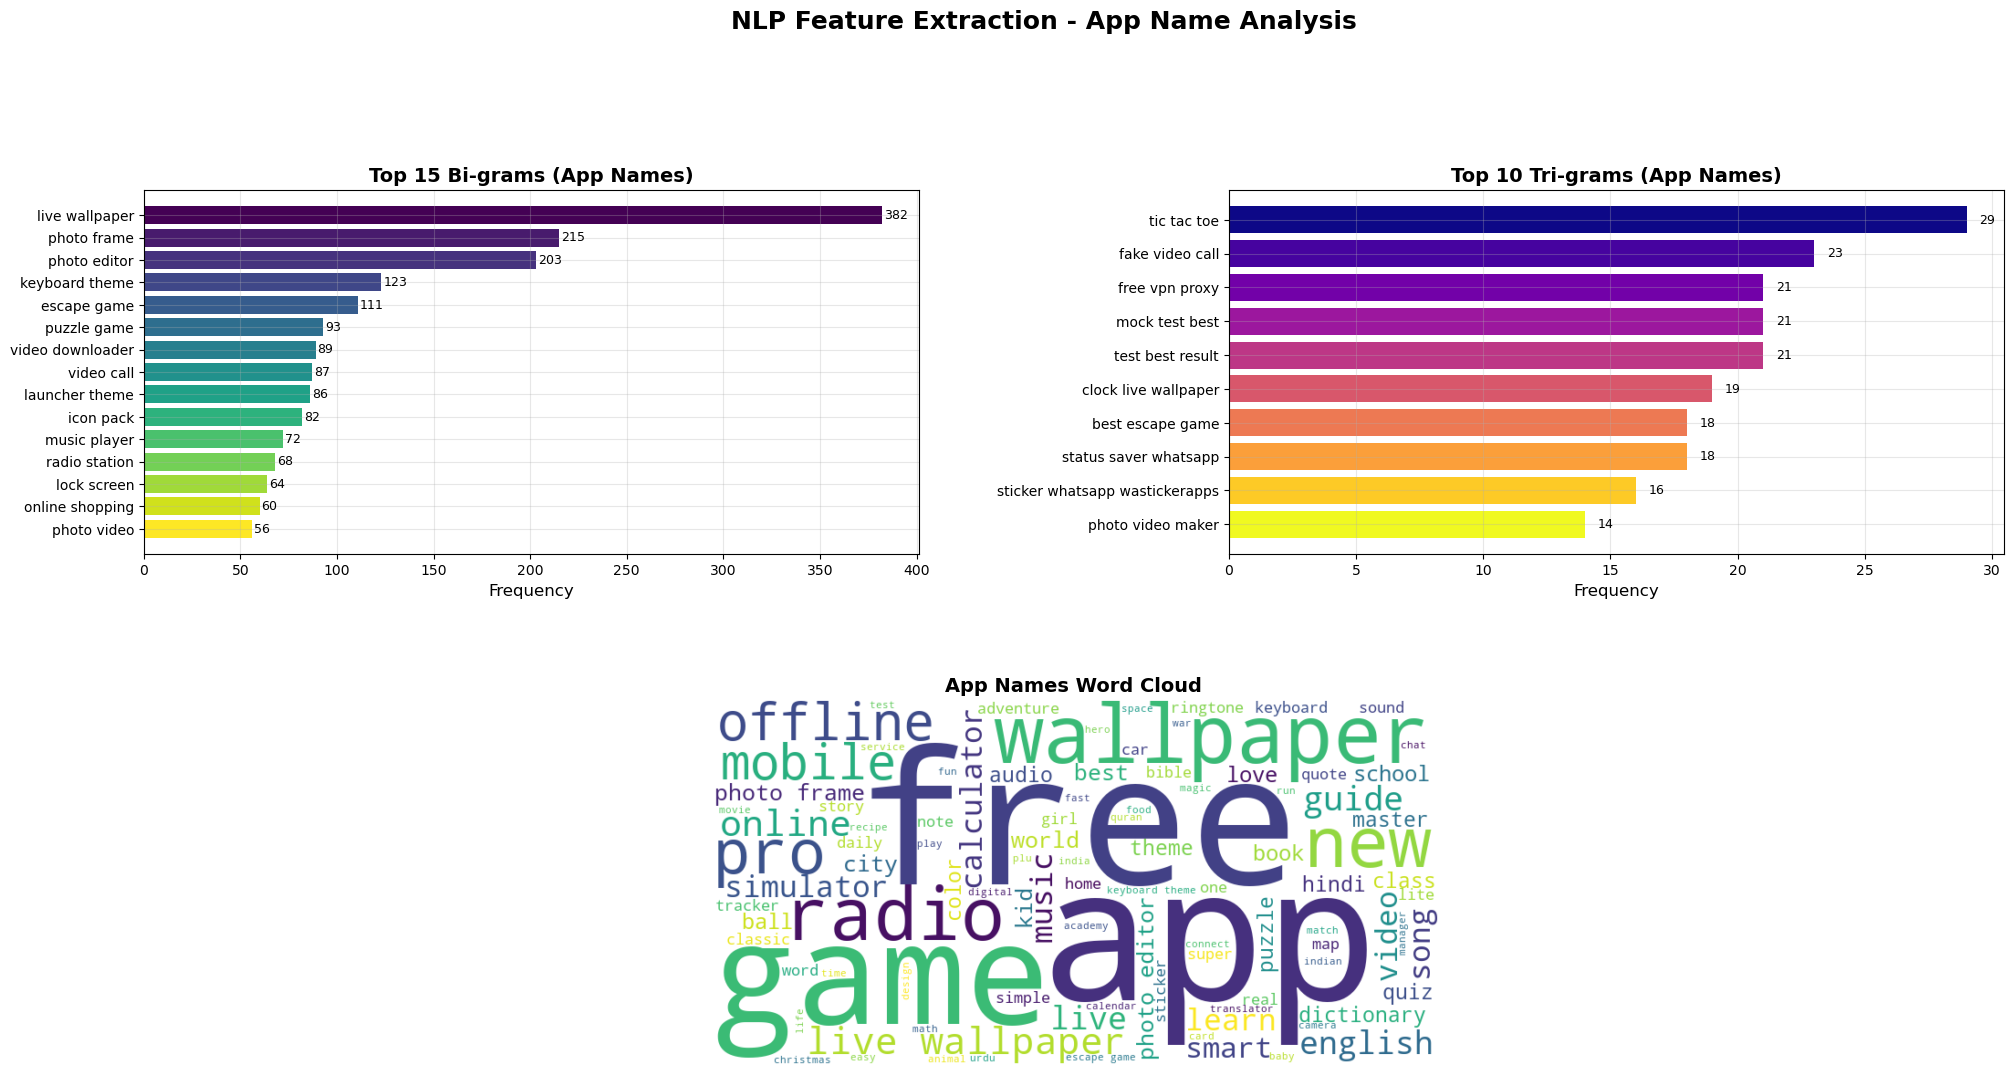

Most Common Bi-grams (App Names):
'live wallpaper': 382
'photo frame': 215
'photo editor': 203
'keyboard theme': 123
'escape game': 111
'puzzle game': 93
'video downloader': 89
'video call': 87
'launcher theme': 86
'icon pack': 82

Most Common Tri-grams (App Names):
'tic tac toe': 29
'fake video call': 23
'free vpn proxy': 21
'mock test best': 21
'test best result': 21
'clock live wallpaper': 19
'best escape game': 18
'status saver whatsapp': 18
'sticker whatsapp wastickerapps': 16
'photo video maker': 14


In [25]:
# ===============================
# 6. NLP Analysis - App Name Feature Extraction (with Visualizations)
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.patches as patches

print("\n=== NLP Feature Extraction - App Name Analysis ===")

# Download NLTK data (required for first run)
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Preprocess app names
df_analysis['App_Name_Clean'] = df_analysis['App Name'].apply(preprocess_text)
# Remove empty app names
df_nlp = df_analysis[df_analysis['App_Name_Clean'].str.len() > 0].copy()

if len(df_nlp) > 0:
    # Set font support
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
    plt.rcParams['axes.unicode_minus'] = False
    
    # Create figure layout - increase overall size and spacing
    fig = plt.figure(figsize=(24, 18))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.4)
    
    # N-gram feature extraction
    # Bi-gram analysis
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=100, min_df=10)
    bigram_matrix = bigram_vectorizer.fit_transform(df_nlp['App_Name_Clean'])
    bigram_features = bigram_vectorizer.get_feature_names_out()
    
    # Tri-gram analysis  
    trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=50, min_df=5)
    trigram_matrix = trigram_vectorizer.fit_transform(df_nlp['App_Name_Clean'])
    trigram_features = trigram_vectorizer.get_feature_names_out()
    
    # 1. Bi-gram frequency visualization
    ax1 = fig.add_subplot(gs[0, 0])
    bigram_counts = np.sum(bigram_matrix.toarray(), axis=0)
    bigram_freq = list(zip(bigram_features, bigram_counts))
    bigram_freq.sort(key=lambda x: x[1], reverse=True)
    
    top_bigrams = bigram_freq[:15]
    bigram_words, bigram_counts_list = zip(*top_bigrams)
    
    bars1 = ax1.barh(range(len(bigram_words)), bigram_counts_list, 
                    color=plt.cm.viridis(np.linspace(0, 1, len(bigram_words))))
    ax1.set_yticks(range(len(bigram_words)))
    ax1.set_yticklabels(bigram_words, fontsize=10)
    ax1.set_xlabel('Frequency', fontsize=12)
    ax1.set_title('Top 15 Bi-grams (App Names)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
                ha='left', va='center', fontsize=9)
    
    # 2. Tri-gram frequency visualization
    ax2 = fig.add_subplot(gs[0, 1])
    trigram_counts = np.sum(trigram_matrix.toarray(), axis=0)
    trigram_freq = list(zip(trigram_features, trigram_counts))
    trigram_freq.sort(key=lambda x: x[1], reverse=True)
    
    top_trigrams = trigram_freq[:10]
    trigram_words, trigram_counts_list = zip(*top_trigrams)
    
    bars2 = ax2.barh(range(len(trigram_words)), trigram_counts_list,
                    color=plt.cm.plasma(np.linspace(0, 1, len(trigram_words))))
    ax2.set_yticks(range(len(trigram_words)))
    ax2.set_yticklabels(trigram_words, fontsize=10)
    ax2.set_xlabel('Frequency', fontsize=12)
    ax2.set_title('Top 10 Tri-grams (App Names)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
                ha='left', va='center', fontsize=9)
    
    # 3. Word cloud
    ax3 = fig.add_subplot(gs[1, :])
    all_text = ' '.join(df_nlp['App_Name_Clean'])
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap='viridis',
                         max_words=100,
                         relative_scaling=0.5).generate(all_text)
    ax3.imshow(wordcloud, interpolation='bilinear')
    ax3.axis('off')
    ax3.set_title('App Names Word Cloud', fontsize=14, fontweight='bold')
    
    plt.suptitle('NLP Feature Extraction - App Name Analysis', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("Most Common Bi-grams (App Names):")
    for feature, count in bigram_freq[:10]:
        print(f"'{feature}': {count}")
    
    print("\nMost Common Tri-grams (App Names):")
    for feature, count in trigram_freq[:10]:
        print(f"'{feature}': {count}")
    
else:
    print("Not enough data for NLP analysis")

In [24]:
# ===============================
# 5.2 Enhanced Statistical Test Analysis
# ===============================

import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("\n=== Enhanced Statistical Significance Testing ===")

# Data preparation and cleaning
free_ratings = df_analysis[df_analysis['Price_Clean'] == 0]['Rating'].dropna()
paid_ratings = df_analysis[df_analysis['Price_Clean'] > 0]['Rating'].dropna()

print(f"Number of free apps: {len(free_ratings)}")
print(f"Number of paid apps: {len(paid_ratings)}")
print(f"Average rating of free apps: {free_ratings.mean():.4f} ± {free_ratings.std():.4f}")
print(f"Average rating of paid apps: {paid_ratings.mean():.4f} ± {paid_ratings.std():.4f}")

# ===============================
# 1. Data Distribution Checking and Assumption Verification
# ===============================

print("\n=== Data Distribution Diagnostics ===")

# Normality tests
def normality_tests(data, name):
    print(f"\n{name} Normality Tests:")
    
    # Shapiro-Wilk test (suitable for small samples)
    if len(data) <= 5000:
        shapiro_stat, shapiro_p = stats.shapiro(data)
        print(f"Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.6f}")
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"K-S test: statistic={ks_stat:.4f}, p-value={ks_p:.6f}")
    
    # Anderson-Darling test
    ad_stat, ad_crit, ad_sig = stats.anderson(data, dist='norm')
    print(f"Anderson-Darling test: statistic={ad_stat:.4f}")
    
    # Skewness and kurtosis
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    print(f"Skewness: {skewness:.4f}, Kurtosis: {kurtosis:.4f}")

# Test normality of both datasets
normality_tests(free_ratings, "Free Apps")
normality_tests(paid_ratings, "Paid Apps")

# Homogeneity of variance test
levene_stat, levene_p = stats.levene(free_ratings, paid_ratings)
print(f"\nLevene's test for homogeneity of variance: statistic={levene_stat:.4f}, p-value={levene_p:.6f}")

# Welch's t-test (does not assume equal variances)
welch_stat, welch_p = stats.ttest_ind(free_ratings, paid_ratings, equal_var=False)
print(f"Welch's t-test (unequal variances): t-statistic={welch_stat:.4f}, p-value={welch_p:.6f}")

# ===============================
# 2. Effect Size Calculation
# ===============================

print("\n=== Effect Size Analysis ===")

# Cohen's d
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1-1)*group1.var() + (n2-1)*group2.var()) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

cohens_d_value = cohens_d(free_ratings, paid_ratings)
print(f"Cohen's d: {cohens_d_value:.4f}")

# Interpret effect size
if abs(cohens_d_value) < 0.2:
    effect_size = "small"
elif abs(cohens_d_value) < 0.5:
    effect_size = "medium"
elif abs(cohens_d_value) < 0.8:
    effect_size = "large"
else:
    effect_size = "very large"

print(f"Effect size interpretation: {effect_size} effect")

# ===============================
# 3. Robust Statistical Tests
# ===============================

print("\n=== Robust Statistical Tests ===")

# Brunner-Munzel test (more robust non-parametric test)
try:
    bm_stat, bm_p = stats.brunnermunzel(free_ratings, paid_ratings)
    print(f"Brunner-Munzel test: statistic={bm_stat:.4f}, p-value={bm_p:.6f}")
except:
    print("Brunner-Munzel test not available")

# Permutation test
def permutation_test(group1, group2, n_permutations=10000):
    observed_diff = group1.mean() - group2.mean()
    combined = np.concatenate([group1, group2])
    n1 = len(group1)
    
    permuted_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_group1 = combined[:n1]
        perm_group2 = combined[n1:]
        permuted_diffs.append(perm_group1.mean() - perm_group2.mean())
    
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
    return observed_diff, p_value

perm_diff, perm_p = permutation_test(free_ratings.values, paid_ratings.values)
print(f"Permutation test: observed difference={perm_diff:.4f}, p-value={perm_p:.6f}")

# ===============================
# 4. Stratified Analysis
# ===============================

print("\n=== Stratified Analysis ===")

# Stratify by rating range
def stratified_analysis():
    rating_bins = [1.0, 2.0, 3.0, 4.0, 5.0]
    for i in range(len(rating_bins)-1):
        lower, upper = rating_bins[i], rating_bins[i+1]
        
        free_subset = free_ratings[(free_ratings >= lower) & (free_ratings < upper)]
        paid_subset = paid_ratings[(paid_ratings >= lower) & (paid_ratings < upper)]
        
        if len(free_subset) > 0 and len(paid_subset) > 0:
            u_stat, u_p = stats.mannwhitneyu(free_subset, paid_subset, 
                                           alternative='two-sided')
            print(f"Rating range [{lower}, {upper}): Free={len(free_subset)}, "
                  f"Paid={len(paid_subset)}, U-test p-value={u_p:.6f}")

stratified_analysis()

# ===============================
# 5. Bootstrap Confidence Intervals
# ===============================

print("\n=== Bootstrap Confidence Interval Analysis ===")

def bootstrap_mean_diff(group1, group2, n_bootstrap=1000, confidence=0.95):
    bootstrap_diffs = []
    n1, n2 = len(group1), len(group2)
    
    for _ in range(n_bootstrap):
        boot_group1 = np.random.choice(group1, size=n1, replace=True)
        boot_group2 = np.random.choice(group2, size=n2, replace=True)
        bootstrap_diffs.append(boot_group1.mean() - boot_group2.mean())
    
    alpha = 1 - confidence
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    ci_lower = np.percentile(bootstrap_diffs, lower_percentile)
    ci_upper = np.percentile(bootstrap_diffs, upper_percentile)
    
    return np.mean(bootstrap_diffs), ci_lower, ci_upper

boot_mean, boot_ci_lower, boot_ci_upper = bootstrap_mean_diff(
    free_ratings.values, paid_ratings.values)

print(f"Bootstrap mean difference: {boot_mean:.4f}")
print(f"95% confidence interval: [{boot_ci_lower:.4f}, {boot_ci_upper:.4f}]")

# ===============================
# 6. Tests After Data Transformation
# ===============================

print("\n=== Tests After Data Transformation ===")

# Box-Cox transformation
def try_transformations():
    # Since rating data may contain negative values or zeros, use Yeo-Johnson transformation
    transformer = PowerTransformer(method='yeo-johnson', standardize=False)
    
    # Combine data for transformation
    combined_ratings = np.concatenate([free_ratings, paid_ratings])
    transformed = transformer.fit_transform(combined_ratings.reshape(-1, 1)).flatten()
    
    # Separate transformed data
    free_transformed = transformed[:len(free_ratings)]
    paid_transformed = transformed[len(free_ratings):]
    
    # Test on transformed data
    t_stat_trans, t_p_trans = stats.ttest_ind(free_transformed, paid_transformed)
    u_stat_trans, u_p_trans = stats.mannwhitneyu(free_transformed, paid_transformed, 
                                                alternative='two-sided')
    
    print(f"After Yeo-Johnson transformation:")
    print(f"t-test: t-statistic={t_stat_trans:.4f}, p-value={t_p_trans:.6f}")
    print(f"Mann-Whitney U test: U-statistic={u_stat_trans:.4f}, p-value={u_p_trans:.6f}")
    
    return free_transformed, paid_transformed

free_trans, paid_trans = try_transformations()

# ===============================
# 7. Comprehensive Results Summary
# ===============================

print("\n=== Comprehensive Analysis Results ===")

# Original t-test and U-test results
t_stat, t_p = stats.ttest_ind(free_ratings, paid_ratings)
u_stat, u_p = stats.mannwhitneyu(free_ratings, paid_ratings, alternative='two-sided')

print(f"Original data results:")
print(f"- t-test: t={t_stat:.4f}, p={t_p:.6f} {'(significant)' if t_p < 0.05 else '(not significant)'}")
print(f"- Mann-Whitney U: U={u_stat:.4f}, p={u_p:.6f} {'(significant)' if u_p < 0.05 else '(not significant)'}")
print(f"- Welch's t-test: t={welch_stat:.4f}, p={welch_p:.6f} {'(significant)' if welch_p < 0.05 else '(not significant)'}")
print(f"- Permutation test: p={perm_p:.6f} {'(significant)' if perm_p < 0.05 else '(not significant)'}")
print(f"- Effect size (Cohen's d): {cohens_d_value:.4f} ({effect_size} effect)")

print(f"\nRecommendations:")
if t_p < 0.05 and u_p >= 0.05:
    print("- t-test is significant but U-test is not, possible distribution differences or outlier effects")
    print("- Recommend reporting Welch's t-test results (more robust)")
    print("- Consider using permutation test results as supplementary")
    print("- Report effect size to evaluate practical significance")
elif perm_p < 0.05:
    print("- Permutation test is significant, indicating real differences exist")
    print("- Recommend reporting multiple test results simultaneously")

print("Analysis completed! Please review the results above.")


=== Enhanced Statistical Significance Testing ===
Number of free apps: 48908
Number of paid apps: 1068
Average rating of free apps: 4.0971 ± 0.6922
Average rating of paid apps: 4.1550 ± 0.5940

=== Data Distribution Diagnostics ===

Free Apps Normality Tests:
K-S test: statistic=0.1089, p-value=0.000000
Anderson-Darling test: statistic=850.7424
Skewness: -1.1052, Kurtosis: 1.3945

Paid Apps Normality Tests:
Shapiro-Wilk test: statistic=0.9174, p-value=0.000000
K-S test: statistic=0.1167, p-value=0.000000
Anderson-Darling test: statistic=19.8123
Skewness: -1.2081, Kurtosis: 1.8897

Levene's test for homogeneity of variance: statistic=28.1243, p-value=0.000000
Welch's t-test (unequal variances): t-statistic=-3.1398, p-value=0.001735

=== Effect Size Analysis ===
Cohen's d: -0.0839
Effect size interpretation: small effect

=== Robust Statistical Tests ===
Brunner-Munzel test: statistic=1.8185, p-value=0.069254
Permutation test: observed difference=-0.0579, p-value=0.006800

=== Stratifie